In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%env DATA_ROOT /content/drive/MyDrive/atmacup11/

env: DATA_ROOT=/content/drive/MyDrive/atmacup11/


In [5]:
import os

import pandas as pd
import numpy as np
from glob import  glob

import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
dataset_root = os.environ.get('DATA_ROOT', None)
assert dataset_root is not None

input_dir = os.path.join(dataset_root, "inputs")
photo_dir = os.path.join(input_dir, "photos")

output_dir = os.path.join(dataset_root, "outputs_tutorial#2__simple")
os.makedirs(output_dir, exist_ok=True)

photo_pathes = glob(os.path.join(photo_dir, "*.jpg"))

In [7]:
glob(dataset_root+'/inputs/*')

['/content/drive/MyDrive/atmacup11//inputs/atmaCup#11_sample_submission.csv',
 '/content/drive/MyDrive/atmacup11//inputs/train.csv',
 '/content/drive/MyDrive/atmacup11//inputs/techniques.csv',
 '/content/drive/MyDrive/atmacup11//inputs/test.csv',
 '/content/drive/MyDrive/atmacup11//inputs/materials.csv',
 '/content/drive/MyDrive/atmacup11//inputs/photos.zip',
 '/content/drive/MyDrive/atmacup11//inputs/photos']

In [8]:

input_dir = os.path.join(dataset_root, "inputs")
photo_dir = os.path.join(input_dir, "photos")

output_dir = os.path.join(dataset_root, "outputs_tutorial#2__simple")
os.makedirs(output_dir, exist_ok=True)

train_df = pd.read_csv(os.path.join(input_dir, 'train.csv'))
test_df = pd.read_csv(os.path.join(input_dir, 'test.csv'))

material_df = pd.read_csv(os.path.join(input_dir, 'materials.csv'))
technique_df = pd.read_csv(os.path.join(input_dir, 'techniques.csv'))

### 基本の設定

### Seed の固定

再現性を取るため

In [9]:
import os
import random

import numpy as np
import torch


def seed_torch(seed=510):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [10]:
import matplotlib.pyplot as plt

import os

import pandas as pd
import numpy as np
from glob import  glob

In [11]:
class Config:
    N_FOLDS = 1
    N_EPOCHS = 10

In [12]:
from PIL import Image

def to_img_path(object_id):
    return os.path.join(photo_dir, f'{object_id}.jpg')

def read_image(object_id):
    return Image.open(to_img_path(object_id))

In [13]:
import torch
from torch import nn
from torch.optim import Adam
from torch.optim.optimizer import Optimizer
from torch.utils import data

# torchvision
from torchvision import transforms as T
from torchvision.models import resnet34

# scikit-learn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [14]:
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]

class AtmaDataset(data.Dataset):
    """atmaCup用にデータ読み込み等を行なうデータ・セット"""
    object_path_key = "object_path"
    label_key = "target"

    @property
    def meta_keys(self):
        retval = [self.object_path_key]

        if self.is_train:
            retval += [self.label_key]

        return retval

    def __init__(self, meta_df: pd.DataFrame, is_train=True):
        """
        args:
            meta_df: 
                画像へのパスと label 情報が含まれている dataframe
                必ず object_path に画像へのパス, target に正解ラベルが入っている必要があります
            
            is_train:
                True のとき学習用のデータ拡張を適用します.
                False の時は単に size にリサイズを行います
        """

        self.is_train = is_train
        self.meta_df = meta_df.reset_index(drop=True)
        self.index_to_data = self.meta_df.to_dict(orient="index")

        size = (224, 224)

        additional_items = (
            [T.Resize(size)]
            if not is_train
            else [
                T.RandomGrayscale(p=0.2),
                T.RandomVerticalFlip(),
                T.RandomHorizontalFlip(),
                T.RandomResizedCrop(size),
            ]
        )

        self.transformer = T.Compose(
            [*additional_items, T.ToTensor(), T.Normalize(mean=IMG_MEAN, std=IMG_STD)]
        )

    def __getitem__(self, index):
        data = self.index_to_data[index]

        obj_path, label = data.get(self.object_path_key), data.get(self.label_key, -1)
        img = Image.open(obj_path)
        img = self.transformer(img)
        return img, label

    def __len__(self):
        return len(self.meta_df)

In [15]:
# CUDA を使うので確認. google colab の場合 GPU accelerator をオンにしておいてください
assert torch.cuda.is_available()

DEVICE = torch.device("cuda")

## Train / Validation Phase

In [16]:
def train(
    model: nn.Module,
    optimizer: Optimizer,
    train_loader: data.DataLoader
) -> pd.Series:

    # train にすることで model 内の学習時にのみ有効な機構が有効になります (Dropouts Layers、BatchNorm Layers...)
    model.train()
    
    criterion = nn.MSELoss()
    
    for i, (x_i, y_i) in enumerate(train_loader):
        x_i = x_i.to(DEVICE)
        y_i = y_i.to(DEVICE).reshape(-1, 1).float()

        output = model(x_i)
        loss = criterion(output, y_i)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def predict(model: nn.Module, loader: data.DataLoader) -> np.ndarray:
    # train とは逆で model 内の学習時にのみ有効な機構がオフになります (Dropouts Layers、BatchNorm Layers...)
    model.eval()
    
    predicts = []
    
    for x_i, y_i in loader:
        
        # 明示的に勾配を計算しないように指定することができます. 
        # この関数ではモデルの更新はせずに単に出力だけを使いますので勾配は不要です.
        with torch.no_grad():
            output = model(x_i.to(DEVICE))

        predicts.extend(output.data.cpu().numpy())

    pred = np.array(predicts).reshape(-1)
    return pred


def calculate_metrics(y_true, y_pred) -> dict:
    """正解ラベルと予測ラベルから指標を計算する"""    
    return {
        'rmse': mean_squared_error(y_true, y_pred) ** .5
    }


def valid(
    model: nn.Module, 
    y_valid: np.ndarray, 
    valid_loader: data.DataLoader
) -> pd.Series:
    """検証フェーズ
    与えられたモデル・データローダを使って検証フェーズを実行。スコアの dict と予測した値を返す
    """
    
    pred = predict(model, valid_loader)
    score = calculate_metrics(y_valid, pred)
    return score, pred

## Run Fold

1. train / valid の loader 作成
2. 以下を epoch 数だけ繰り返す
    1. 学習用データで学習 
    2. 検証用データで検証スコアの算出

In [17]:
def run_fold(
    model: nn.Module, 
    train_df: pd.DataFrame, 
    valid_df: pd.DataFrame, 
    y_valid: np.ndarray, 
    n_epochs=30) -> np.ndarray:
    """
    train / valid に分割されたデータで学習と同時に検証を行なう
    """
    
    # 0: 
    #   : 前準備. dataframe から data loader を作成
    train_dataset = AtmaDataset(meta_df=train_df)
    train_loader = data.DataLoader(
        train_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=4
    )
    
    #   : 検証用の方は is_train=False にしてデータ拡張オフにする
    valid_dataset = AtmaDataset(meta_df=valid_df, is_train=False)
    valid_loader = data.DataLoader(valid_dataset, batch_size=256, num_workers=4)
    
    # optimizer の定義
    optimizer = Adam(model.parameters(), lr=1e-3)

    for epoch in range(1, n_epochs + 1):
        print(f'start {epoch}')
        
        # 1: 学習用データで学習を実行。学習時のロスを取得
        train(model, optimizer, train_loader)

        # 2: 検証データでのスコアを計算
        score_valid, y_valid_pred = valid(model=model, valid_loader=valid_loader, y_valid=y_valid)

        print(score_valid)

### その他

モデル作成などの関数定義

In [18]:
def create_model():
    model = resnet34(pretrained=False)
    model.fc = nn.Linear(in_features=512, out_features=1, bias=True)    
    return model
    
def create_metadata(input_df):
    out_df = input_df[['object_id']].copy()
    out_df['object_path'] = input_df['object_id'].map(to_img_path)
    
    if "target" in input_df:
        out_df["target"] = input_df["target"]

    return out_df

def run_test_predict(model):
    test_meta_df = create_metadata(test_df)

    # 学習時のデータ拡張はオフにしたいので is_train=False としている
    test_dataset = AtmaDataset(meta_df=test_meta_df, is_train=False)
    test_loader = data.DataLoader(dataset=test_dataset, batch_size=128, drop_last=False, num_workers=4)
    
    y_pred = predict(model, loader=test_loader)
    return y_pred

In [19]:
def run_fold(
    model: nn.Module, 
    train_df: pd.DataFrame, 
    valid_df: pd.DataFrame, 
    y_valid: np.ndarray, 
    n_epochs=30) -> np.ndarray:
    """
    train / valid に分割されたデータで学習と同時に検証を行なう
    """
    
    # 0: 
    #   : 前準備. dataframe から data loader を作成
    train_dataset = AtmaDataset(meta_df=train_df)
    train_loader = data.DataLoader(
        train_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=4
    )
    
    #   : 検証用の方は is_train=False にしてデータ拡張オフにする
    valid_dataset = AtmaDataset(meta_df=valid_df, is_train=False)
    valid_loader = data.DataLoader(valid_dataset, batch_size=256, num_workers=4)
    
    # optimizer の定義
    optimizer = Adam(model.parameters(), lr=1e-3)

    for epoch in range(1, n_epochs + 1):
        print(f'start {epoch}')
        
        # 1: 学習用データで学習を実行。学習時のロスを取得
        train(model, optimizer, train_loader)

        # 2: 検証データでのスコアを計算
        score_valid, y_valid_pred = valid(model=model, valid_loader=valid_loader, y_valid=y_valid)

        print(score_valid)

### その他

モデル作成などの関数定義

In [20]:
def create_model():
    model = resnet34(pretrained=False)
    model.fc = nn.Linear(in_features=512, out_features=1, bias=True)    
    return model
    
def create_metadata(input_df):
    out_df = input_df[['object_id']].copy()
    out_df['object_path'] = input_df['object_id'].map(to_img_path)
    
    if "target" in input_df:
        out_df["target"] = input_df["target"]

    return out_df

def run_test_predict(model):
    test_meta_df = create_metadata(test_df)

    # 学習時のデータ拡張はオフにしたいので is_train=False としている
    test_dataset = AtmaDataset(meta_df=test_meta_df, is_train=False)
    test_loader = data.DataLoader(dataset=test_dataset, batch_size=128, drop_last=False, num_workers=4)
    
    y_pred = predict(model, loader=test_loader)
    return y_pred

## おさらい

前回の学習のコード

In [21]:
train_meta_df = create_metadata(train_df)

fold = KFold(n_splits=5, shuffle=True, random_state=510)
cv = list(fold.split(X=train_df, y=train_df['target']))[:Config.N_FOLDS]

for i, (idx_tr, idx_valid) in enumerate(cv):
    model = create_model()
    model.to(DEVICE)
    
    # 1. Fold の学習
    run_fold(
        model=model, 
        train_df=train_meta_df.iloc[idx_tr], 
        valid_df=train_meta_df.iloc[idx_valid], 
        y_valid=train_meta_df['target'].values[idx_valid],
        n_epochs=10
    )
    
y_pred = run_test_predict(model)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


start 1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 1.0113535065076817}
start 2


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.9608008112434708}
start 3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.9943019574192189}
start 4


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 1.0098729604136005}
start 5


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.972371249449421}
start 6


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.9367059359142605}
start 7


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.9611509504273695}
start 8


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.9599874107706385}
start 9


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.9493527970724498}
start 10


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.9309776181231985}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### TTA

test time augmentation の略です。推論を行なう際にも Augmentation を行ってその平均を取る方法のことです。同じ画像をちょっとずらしたものを何回も推論して平均することで性能が上がる場合があります。

今回は簡易のため学習時に使うのと同様の augmentation を使っています。(これが一番いいというわけではないです)

In [22]:
from tqdm import tqdm

def run_test_predict(model, input_df, n_tta=0):
    test_meta_df = create_metadata(test_df)

    # n_tta > 0 の時だけデータ拡張を on にする (is_train = True)
    is_tta_mode = n_tta > 0
    test_dataset = AtmaDataset(meta_df=input_df, is_train=is_tta_mode)
    test_loader = data.DataLoader(dataset=test_dataset, batch_size=128, drop_last=False, num_workers=4)
    
    predictions = []
    n_times = 1 if not is_tta_mode else n_tta
    print(f"run #{n_times} times / tta={is_tta_mode}")
    for _ in tqdm(range(n_times)):
        y_pred = predict(model, loader=test_loader)
        predictions.append(y_pred)
    
    return np.array(predictions).mean(axis=0)

In [23]:
valid_meta_df = train_meta_df.iloc[idx_valid].reset_index(drop=True)
y_valid = train_meta_df['target'].values[idx_valid] 

In [24]:
dataset = AtmaDataset(train_meta_df, is_train=True)

### Augmentation の確認

以下のセルを実行すると毎回画像が変わるのは、都度ランダムに augmentation が決定されるため。

In [25]:
# TTAを行わない場合の予測
y_pred_no_tta = run_test_predict(model, valid_meta_df, n_tta=0)

# 10回分の augmentation を使って TTA を行なう場合の予測
y_pred_tta = run_test_predict(model, valid_meta_df, n_tta=10)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


run #1 times / tta=False


100%|██████████| 1/1 [00:04<00:00,  4.05s/it]


run #10 times / tta=True


100%|██████████| 10/10 [00:42<00:00,  4.22s/it]


In [26]:
calculate_metrics(y_valid, y_pred_no_tta)

{'rmse': 0.9309776181231985}

In [27]:
calculate_metrics(y_valid, y_pred_tta)

{'rmse': 0.9460865946001362}

### 学習率の調整

確率的勾配法の adaptive method (ADAM / AdamW / RAdam...) は自動的に lr を調整するという目的がありますが、それ以外で手動で lr を調整すると性能が向上する場合があります。これを学習率の調整 (learning rate scheduling / scheduler) とよびます。

これまでに様々な LR Scheduing 手法が提案されています。pytorch にもいくつか実装があります。今回は3つの動きを見てみましょう。

In [28]:
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR, ExponentialLR

In [29]:
optimizer = Adam(model.parameters(), lr=1)

schedulers = [
    lambda optim: CosineAnnealingLR(optim, T_max=10), # 周期 10 の cosine
    lambda optim: StepLR(optim, step_size=30, gamma=.2), # 30 epoch ごとに学習率を 0.05 倍
    lambda optim: ExponentialLR(optim, gamma=.95) # 毎 epoch ごとに 0.95 倍
]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


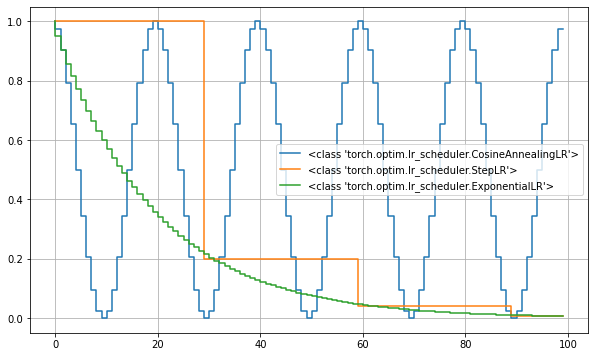

In [30]:
import matplotlib.pyplot as plt

epochs = list(range(100))
fig, ax = plt.subplots(figsize=(10, 6))

for get_scheduler in schedulers:
    rates = []
    sche = get_scheduler(Adam(model.parameters(), lr=1.))
    
    for i in epochs:
        rates.append(sche.get_last_lr()[0])
        sche.step()
        
    ax.step(epochs, rates, label=type(sche))
    
# ax.set_yscale('log')
ax.grid()
ax.legend()

In [31]:
def run_fold(
    model: nn.Module, 
    train_df: pd.DataFrame, 
    valid_df: pd.DataFrame, 
    y_valid: np.ndarray, 
    n_epochs=30) -> np.ndarray:
    """
    """
    
    # 0: 
    #   : 前準備. dataframe から data loader を作成
    train_dataset = AtmaDataset(meta_df=train_df)
    train_loader = data.DataLoader(
        train_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=4
    )
    
    #   : 検証用の方は is_train=False にしてデータ拡張オフにする
    valid_dataset = AtmaDataset(meta_df=valid_df, is_train=False)
    valid_loader = data.DataLoader(valid_dataset, batch_size=256, num_workers=4)
    
    # optimizer の定義
    optimizer = Adam(model.parameters(), lr=1e-3)
    
    # scheduler の定義 / 10 step ごとに学習率を 0.2 倍する
    scheduler = StepLR(optimizer, step_size=10, gamma=.2, verbose=True)

    results = []
    for epoch in range(1, n_epochs + 1):
        print(f'start {epoch}')
        # 1: 学習用データで学習を実行。学習時のロスを取得
        train(model, optimizer, train_loader)

        # 2: 検証データでのスコアを計算
        score_valid, y_valid_pred = valid(model=model, valid_loader=valid_loader, y_valid=y_valid)

        print(score_valid)
        score_valid.update({
            "lr": scheduler.get_last_lr()[0]
        })
        results.append(score_valid)
        
        # scheduler の step をすすめる
        scheduler.step()
    
    return results

In [32]:
scheduled_model = create_model()
scheduled_model.to(DEVICE)

# 1. Fold の学習
results = run_fold(
    model=scheduled_model, 
    train_df=train_meta_df.iloc[idx_tr], 
    valid_df=train_meta_df.iloc[idx_valid], 
    y_valid=train_meta_df['target'].values[idx_valid],
    n_epochs=40
)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Adjusting learning rate of group 0 to 1.0000e-03.
start 1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.9774458954092438}
Adjusting learning rate of group 0 to 1.0000e-03.
start 2


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.9982039207704646}
Adjusting learning rate of group 0 to 1.0000e-03.
start 3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 1.0023256060621848}
Adjusting learning rate of group 0 to 1.0000e-03.
start 4


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.9640283770378829}
Adjusting learning rate of group 0 to 1.0000e-03.
start 5


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 1.0921878763560926}
Adjusting learning rate of group 0 to 1.0000e-03.
start 6


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.9251534991065135}
Adjusting learning rate of group 0 to 1.0000e-03.
start 7


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.9966388360131447}
Adjusting learning rate of group 0 to 1.0000e-03.
start 8


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 1.114792695766548}
Adjusting learning rate of group 0 to 1.0000e-03.
start 9


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.9422150248096967}
Adjusting learning rate of group 0 to 1.0000e-03.
start 10


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 1.320100191785605}
Adjusting learning rate of group 0 to 2.0000e-04.
start 11


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.9168492857346681}
Adjusting learning rate of group 0 to 2.0000e-04.
start 12


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.9015368138152625}
Adjusting learning rate of group 0 to 2.0000e-04.
start 13


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.9033196860427406}
Adjusting learning rate of group 0 to 2.0000e-04.
start 14


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 1.0067443436388224}
Adjusting learning rate of group 0 to 2.0000e-04.
start 15


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.9349333063531405}
Adjusting learning rate of group 0 to 2.0000e-04.
start 16


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.9016549393458085}
Adjusting learning rate of group 0 to 2.0000e-04.
start 17


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.9402799402965224}
Adjusting learning rate of group 0 to 2.0000e-04.
start 18


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.9428173575027621}
Adjusting learning rate of group 0 to 2.0000e-04.
start 19


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.8798100956011153}
Adjusting learning rate of group 0 to 2.0000e-04.
start 20


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.9807269885220566}
Adjusting learning rate of group 0 to 4.0000e-05.
start 21


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.8744731236855969}
Adjusting learning rate of group 0 to 4.0000e-05.
start 22


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.8857296926377688}
Adjusting learning rate of group 0 to 4.0000e-05.
start 23


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.8687337972088824}
Adjusting learning rate of group 0 to 4.0000e-05.
start 24


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.8697572510608763}
Adjusting learning rate of group 0 to 4.0000e-05.
start 25


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.8674378306746554}
Adjusting learning rate of group 0 to 4.0000e-05.
start 26


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.8754627987992699}
Adjusting learning rate of group 0 to 4.0000e-05.
start 27


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.8629868475722418}
Adjusting learning rate of group 0 to 4.0000e-05.
start 28


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.8786517446824471}
Adjusting learning rate of group 0 to 4.0000e-05.
start 29


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.8618255733598067}
Adjusting learning rate of group 0 to 4.0000e-05.
start 30


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.8741085243907442}
Adjusting learning rate of group 0 to 8.0000e-06.
start 31


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.8628091151378308}
Adjusting learning rate of group 0 to 8.0000e-06.
start 32


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.8596708788805526}
Adjusting learning rate of group 0 to 8.0000e-06.
start 33


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.8615667487402461}
Adjusting learning rate of group 0 to 8.0000e-06.
start 34


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.8618106110217584}
Adjusting learning rate of group 0 to 8.0000e-06.
start 35


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.8622366139454607}
Adjusting learning rate of group 0 to 8.0000e-06.
start 36


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.8617082923556373}
Adjusting learning rate of group 0 to 8.0000e-06.
start 37


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.8619647232355934}
Adjusting learning rate of group 0 to 8.0000e-06.
start 38


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.8643841915566853}
Adjusting learning rate of group 0 to 8.0000e-06.
start 39


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.8626806616911222}
Adjusting learning rate of group 0 to 8.0000e-06.
start 40


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rmse': 0.8605553567055577}
Adjusting learning rate of group 0 to 1.6000e-06.


In [33]:
log_df = pd.DataFrame(results)

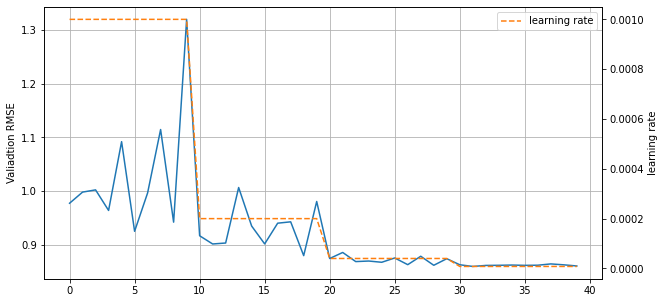

In [34]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(log_df['rmse'])
ax.grid()
ax.set_ylabel("Valiadtion RMSE")

ax2 = ax.twinx()
ax2.plot(log_df["lr"], "--", c="C1", label="learning rate")
ax2.set_ylabel("learning rate")
ax2.legend()

In [35]:
# TTAを行わない場合の予測
y_pred_no_tta = run_test_predict(scheduled_model, valid_meta_df, n_tta=0)

# 10回分の augmentation を使って TTA を行なう場合の予測
y_pred_tta = run_test_predict(scheduled_model, valid_meta_df, n_tta=10)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


run #1 times / tta=False


100%|██████████| 1/1 [00:03<00:00,  3.24s/it]


run #10 times / tta=True


100%|██████████| 10/10 [00:35<00:00,  3.58s/it]


In [36]:
calculate_metrics(y_valid, y_pred_no_tta), calculate_metrics(y_valid, y_pred_tta)

({'rmse': 0.8605553567055577}, {'rmse': 0.8688321736985485})

## 質問に答えるコーナー

### これからどうやっていく?

* 私もbaselineから先に進むにはどうすれば良いか、アイデアを知りたいです。kaggleでも、baselineを公開notebookとして下さる方が多い（ありがたい！！）のですが、そこから自分なりのものをつくることができません…
* 画像コンペが初めてなのですが、昨日の内容の後、何を考えてどう進めればいいのかがイメージがついていません。テーブルデータだとベースライン作った後はガシガシ特徴量作ろうとか思えるのですが、画像コンペの場合はどう進めるのがよいか、触れていただけないでしょうか。

----

#### ディスカッションを読む

たくさんの有用情報がありますので、あるものは全部見て試せそうなものを試していきましょう

例えば  self supervised learning などでの事前学習が紹介されています。今回のコンペティションでは事前学習モデルを使えませんが、自己教師あり学習を使うことで、普通に学習を行なうよりもより良い初期値から学習が出来るため、性能向上に繋がる可能性があります。

#### 安定した validation を確保する

これはテーブルと同じですが、CVの値とLBの値が乖離していないかは常に大事です。

#### データを理解する

* どんな画像が含まれているか
  * 実際に見てみる
* このデータがどのように生成されているか
  * train / test の分割
  * target (年代) と他の要素との関係性

#### 学習フローを仮説検証をして改良する

* Fold の切り方
* data augmentation
  * どの augmentation が効いているか。ない方がいい場合もある。
* 画像以外の情報は有効か?

#### 余りやらないほうが良いこと

* optimizer の細かいチューニング
    * 滅茶苦茶大きく効いてくるものではないので普通に学習ができているのであればそこは固定で別の探索をしたほうが良い場合が多い印象です。

#### その他: 実験を管理する方法を考えておく

atmaCupは2週間と短いですが、とはいえたくさんの条件で実験をすることになります。何も考えず手当たりしだいにやっていると、どの条件で実験をしたのかわからなくなり、最悪の場合一番良い submit を作ったコードがわからないなんてことはざらにあります。

なんでも良いのですが自分がやったことを振り替えれるような仕組みづくりをしておくことが大切です。例えばやったことを追跡可能な形で日記にすることを提案している方法 [ref1] などとても良いと思います。これに加えて今回紹介した comet-ml や wandb / mlflow などを組み合わせるなどもあるでしょう。

ref

* Kaggle日記という戦い方: https://zenn.dev/fkubota/articles/3d8afb0e919b555ef068

### 画像以外のデータの使い方

* Youtubeにて仰られていた初心者講座#2での希望テーマについて、もしよろしければ「新たに特徴量を追加する場合の流れ」について伺いたいです！（今回のノートブックであればどの段階で追加が必要で、追加で編集する必要がある箇所はどこで、といったイメージです！）
* 画像とテーブルデータの両方がデータセットに含まれる過去のコンペの紹介や効果のあった解法の解説をしていただけるとありがたいです。

----

petfinder や avito など有名だと思います。petfinder は画像とテーブル・自然言語が予測時に使えるコンペティションでした。画像・自然言語に対して事前学習モデル等の出力を得た特徴と、テーブルデータの特徴をマージして勾配ブースティングにかけるという方法が多く見られた用に記憶しています。

ref:

* 優勝(当時は諸事情で2位)チームの discussion https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/102099
* 日本語の解説スライド: https://speakerdeck.com/upura/kaggle-petfinder-2nd-place-solution
* kaggle: Avito Demand Prediction Challenge まとめ: https://copypaste-ds.hatenablog.com/entry/2019/09/08/183255

ただ上記コンペでは予測時にもテーブルデータの情報が使えたのですが、今回のコンペティションは予測時には画像しか使えないということに注意する必要があります。例えばテーブルのカラム(例えば technique.csv) から特徴量を作って予測するモデルを作っても、予測する画像に対して technique は紐付かないので、そもそも特徴量を作ることができません。



### 可視化

* NNは基本ブラックボックスだと思っているのですが、判定根拠を可視化する方法等あれば知りたいです。LGBMで言うところのimportanceのようなものがあれば仮説が立てやすいと思っています。

------

画像のうちどこを重点的に見て判断しているかを可視化する手法がいくつかあり GRAD-CAM が有名です。

* pytorch grad cam: https://github.com/jacobgil/pytorch-grad-cam
* GradCam Examle: https://www.kaggle.com/yukia18/gradcam-example
  * pytorch で gradcam を使う方法。

![Screenshot from 2021-07-14 15-32-38.png](https://storage.guruguru.science/uploads/7c8f7df3_eb43_49ed_9507_740593c52617/Screenshot_from_2021-07-14_15-32-38.png)


In [37]:
# install libs (ttah も必要です.)
!pip install grad-cam ttach

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.8 MB 16.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.3-py3-none-any.whl size=32263 sha256=a353f9426941ed7503a9c40de2f2b17336d482496c28decf35db609dec35bd21
  Stored in directory: /root/.cache/pip/wheels/77/05/47/36e06c7cdf46685b5a9e30686a1f93bff3e95a91bf1404c75d
Successfully built grad-cam


In [38]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [50]:
# 可視化で計算するレイヤーの指定
# resnetはlayer4
target_layer = scheduled_model.layer4[-1]

# 使う画像のindex
index = 1500
# もともとの画像. model に input される (224, 224) に resize しておく
img = read_image(train_meta_df["object_id"].iat[index]).resize((224, 224))

# 画像 → tensor化する必要があるので dataset class を使って楽する
dataset = AtmaDataset(train_meta_df, is_train=False)
x_tensor, label = dataset[index]

In [51]:
target_layer

BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [52]:
train_df.iloc[index]

object_id        6324a29a9b1f3fbb62ab
sorting_date                     1730
art_series_id    262cd803d32dc2789cd0
target                              2
Name: 1500, dtype: object

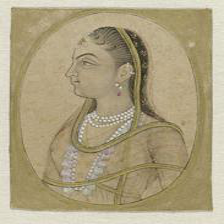

In [53]:
img

In [54]:
x_tensor.unsqueeze(0).shape

torch.Size([1, 3, 224, 224])